# EuroPython 2021 : Drift Detection with alibi-detect

In [1]:
from typing import Tuple, Generator, Callable, Optional
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_train_loader
from wilds import get_dataset
import alibi_detect
import torchvision
import wilds
from alibi_detect.models.pytorch import trainer

print(f"Alibi Detect Version: {alibi_detect.__version__}")
print(f"Torch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Wilds Version: {wilds.__version__}")


torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cpu')
%matplotlib inline


Alibi Detect Version: 0.10.4
Torch Version: 1.10.2
Torchvision Version: 0.11.0a0
Wilds Version: 2.0.0


## Daten
Benutzt wird Camelyon17 medizinischer Datensatz, einer der WILDS Datensätze die "in-the-wild" Verteilungs Verschiebungen repräsentieren für versch. Datenmodalitäten
Enthält Gewebe-Scans die als gut oder bösartig klassifiziert werden.
Die Verteilung vor der Veränderung sind Scans von 3 versch. Krankenhäusern und die Verteilung nach der Veränderung ist aus einem Scan Datensatz von einem neuen Krankenhaus

Koh et a. (2020) zeigen, dass Modelle die auf Scans trainiert wurden mit der Vor Veränderungs Verteilung eine Accuracy von 93.2% auf ungesehenen Scans der gleichen Verteilung haben, aber nur 70.3% Genauigkeit auf Scans von der Verteilung nach Veränderung
<br>
<br>
<img src="camelyon_dataset.jpg" width=500>
<br>

WILDS ist von Standford

Datensatz laden

In [2]:
dataset = get_dataset(dataset="camelyon17",download=True)

In [8]:
WILDS_PATH = 'data'
N = 2500 # Size of reference set
DOWNLOAD = False

Wrapper um einen Stream zu erzeugen der Live Deployment Umgebung simuliert

In [5]:
def stream_camelyon( split: str='train',img_size : Tuple[int]=(96,96),root_dir: str=None,download: bool=False)-> Generator:
    camelyon = get_dataset('camelyon17',root_dir=root_dir,download=download)
    ds = camelyon.get_subset(
        split,transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
    )
    ds_iter = iter(get_train_loader('standard',ds,batch_size=1))
    while True:
        try:
            img = next(ds_iter)[0][0]
        except Exception:
            ds_iter = iter(get_train_loader('standard',ds,batch_size=1))
            img = next(ds_iter)[0][0]
        yield img.numpy()

Dann (x_ref) Referenzdatensatz mit N=2500 Instanzen erzeugen

Dann 2 Streams
- stream_no_change : Instanzen der gleichen Verteilung wie die Trainingsdaten
- stream_change : Instanzen vom gedrifteten Datensatz (das andere Krankenhaus)

Leichte Vereinfachung des Problems weil wir den Zeitpunkt der Änderung auf 0 setzen
Können aber mit den Streams schauen wie lang der Detector läuft
- können dann die AVG. Laufzeit und den Delay beobachten 

In [9]:
stream_train = stream_camelyon(split='train',root_dir=WILDS_PATH,download=DOWNLOAD)
x_ref = np.stack([next(stream_train) for _ in range(N)],axis=0)

stream_no_change = stream_camelyon(split='id_val',root_dir=WILDS_PATH,download=DOWNLOAD)
stream_change = stream_camelyon(split='test',root_dir=WILDS_PATH,download=DOWNLOAD)

Jetzt Stichproben aus der Verteilung **vor** der Veränderung plotten

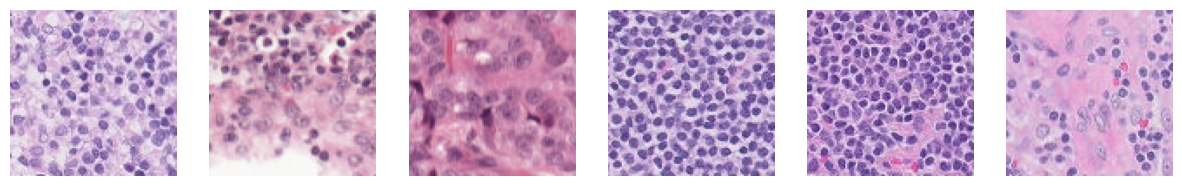

In [10]:
fig, axis = plt.subplots(nrows=1,ncols=6,figsize=(15,4))
for i in range(6):
    axis[i].imshow(np.transpose(next(stream_no_change),(1,2,0)))
    axis[i].axis('off')


Jetzt Stichproben aus der Verteilung **nach** der Veränderung plotten

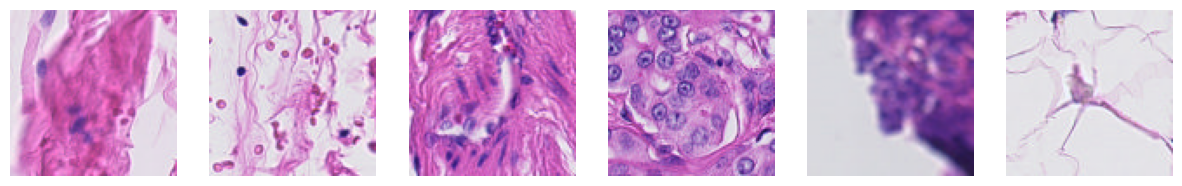

In [11]:
fig, axis = plt.subplots(nrows=1,ncols=6,figsize=(15,4))
for i in range(6):
    axis[i].imshow(np.transpose(next(stream_change),(1,2,0)))
    axis[i].axis('off')


## Drift Detection
- Strategie: Überlappende Fenster
- TEststatistik: Abschätzung mit MMD, die inkrementell geupdated werden kann
### Kernel
- Als Projektion wird ein Autoencoder trainiert, um eine strukturiertere Repräsentation der Daten zu definieren mit niedrigerer Dimension
- **Wichtig:** Trainierte Preprozessor Komponenten müssen auf einem Split der Daten trainiert werden das kein Teil der Daten ist die der Drift Detector als Referenz Daten bekommt

Hier der Autoencoder in Pytorch defininert als sequentielles Pytorch Modell

In [12]:
ENC_DIM = 32
BATCH_SIZE = 32
EPOCHS =5
LEARNING_RATE = 1e-3

encoder = nn.Sequential(
    nn.Conv2d(3,8,5,stride=3,padding=1), # (batch, 8, 32, 32)
    nn.ReLU(),
    nn.Conv2d(8,12,4,stride=2,padding=1), # (batch,12,16,16)
    nn.ReLU(),
    nn.Conv2d(12,16,4,stride=2,padding=1), # (batch,16,8,8)
    nn.ReLU(),
    nn.Conv2d(16,20,4,stride=2,padding=1), # (batch,20,4,4)
    nn.ReLU(),
    nn.Conv2d(20,ENC_DIM,4,stride=1,padding=0), #(batch,enc_dim,1,1)
    nn.Flatten(),   
)
decoder = nn.Sequential(
    nn.Unflatten(1,(ENC_DIM,1,1)),
    nn.ConvTranspose2d(ENC_DIM,20,4,stride=1,padding=0), # [batch,20,4,4]
    nn.ReLU(),
    nn.ConvTranspose2d(20,16,4,stride=2,padding=1), # (batch,16,8,8)
    nn.ReLU(),
    nn.ConvTranspose2d(16,12,4,stride=2,padding=1), # (batch,12,16,16)
    nn.ReLU(),
    nn.ConvTranspose2d(12,8,4,stride=2,padding=1),  # (batch,8,32,32)
    nn.ReLU(),
    nn.ConvTranspose2d(8,3,5,stride=3,padding=1),  # (batch,3,96,96)
    nn.Sigmoid()
)

Hier bekommt das PyTorch Dataloader Modul die Referenzdaten

In [13]:
ae = nn.Sequential(encoder,decoder).to(device)

x_fit, x_ref = np.split(x_ref,[len(x_ref)//2])
x_fit = torch.as_tensor(x_fit)
x_fit_dl = DataLoader(TensorDataset(x_fit,x_fit),BATCH_SIZE,shuffle=True)



Mit alibi-detect den auto-encoder trainieren

In [14]:


trainer(ae,nn.MSELoss(),x_fit_dl,device,learning_rate=LEARNING_RATE,epochs=EPOCHS)

Epoch 5/5: 100%|██████████| 40/40 [00:01<00:00, 21.53it/s, loss_ma=0.0233]


Dann Funktion definieren, die den Encoder des AutoEncoder benutzt um die Bilder zu konvertieren in numpy arrays

In [15]:
def encoder_fn(x: np.ndarray) -> np.array:
    x = torch.as_tensor(x).to(device=device)
    with torch.no_grad():
        x_proj = encoder(x)
    return x_proj.cpu().numpy()

Jetzt haben wir die Projektion für unseren Kernel definiert

### Definieren des Detectors
Wenn der Detektor definiert ist müssen die Referenzdaten, die gewünschte ERT und Window Größe mitgegeben werden.
Die Thresholds werden durch Simulation in einer initialen Konfigurationsphase konfiguriert.

Was wir hier definieren:
- Espected Runtime die gewünscht ist
- Größe der Testfenster
- Anzahl der Simulationen um Thresholds zu konfigurieren

In [16]:
ERT = 150 # Erwartete Laufzeit in Abwesenheit von Drift
W = 20 # Größe des Testfensters
B = 100_000 # Anzahl der Simulationen um Threshold zu konfigurieren

Dann von alibi-detect den MMD Detector importieren 

In [17]:
from alibi_detect.cd import MMDDriftOnline
dd = MMDDriftOnline(x_ref,ERT,W,backend='pytorch',preprocess_fn=encoder_fn)

No GPU detected, fall back on CPU.


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [00:00<00:00, 23.57it/s]


### Anwenden des Detektors

In [18]:
def compute_runtime(detector: Callable, stream: Generator) -> int:
    detector.reset()
    detected = False
    while not detected:
        z = next(stream)
        pred = detector.predict(z)
        detected = pred['data']['is_drift']
    print(detector.t)
    return detector.t

Hier die False Positive Rate

In [19]:
times_h0 = [compute_runtime(dd,stream_no_change) for i in range(15)]
print(f'Average runtime in absence of change: {np.array(times_h0).mean()}')

14
15
156
324
50
15
21
213
160
33
5
462
107
95
163
Average runtime in absence of change: 122.2


Hier können wir die Teststatistik des Detetors sehen und die Thresholds und was passiert 
- Teststatistik fluktuiert um 0 
- dann gibt es eine Fluktuation die über den Threshold geht (bei t=163)

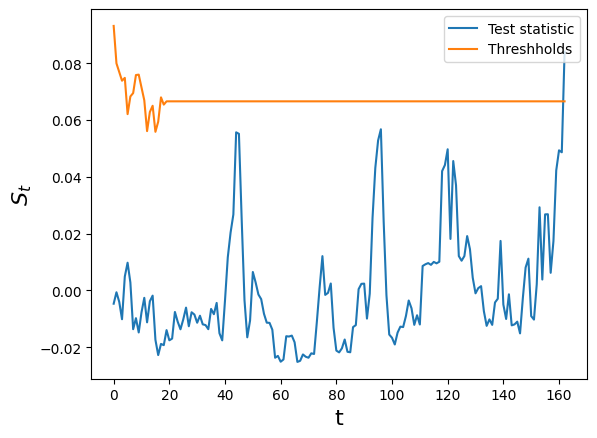

In [20]:
ts = np.arange(dd.t)
plt.plot(ts,dd.test_stats,label='Test statistic')
plt.plot(ts, dd.thresholds,label='Threshholds')
plt.xlabel('t',fontsize=16)
plt.ylabel('$S_t$',fontsize=16)
plt.legend(loc='upper right',fontsize=10)
plt.show()

Detector auf den Stream anwenden wo es eine Veränderung gab
- Läuft hier nur 14 Zeitintervalle (im Durchschnitt) (Abschätzung von Detection Delay)
- Flaggt Drift also viel schneller als wenn es keinen Drift gab

In [21]:
times_h1 = [compute_runtime(dd,stream_change) for i in range(15)]
print(f'Average runtime in the presence of change:{np.array(times_h1).mean()}')

18
10
23
12
21
15
9
19
4
21
18
12
23
2
9
Average runtime in the presence of change:14.4


Teststatistik steigt schnell vom Start, übersteigt Threshold vom Detector schnell 

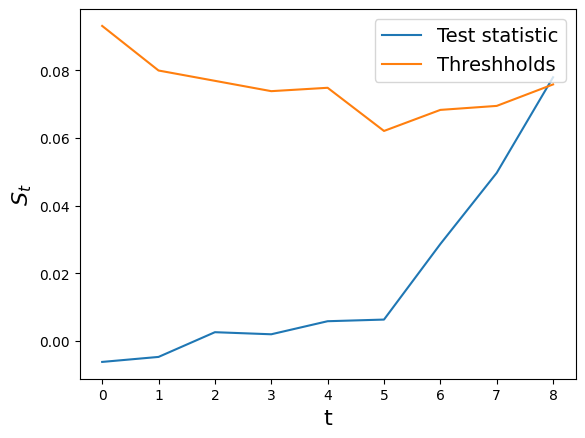

In [41]:
ts = np.arange(dd.t)
plt.plot(ts,dd.test_stats,label='Test statistic')
plt.plot(ts,dd.thresholds,label='Threshholds')
plt.xlabel('t',fontsize=16)
plt.ylabel('$S_t$',fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.show()

# Meine Sandbox

<table>
  <thead>
    <tr>
      <th>Dataset</th>
      <th>Modality</th>
      <th>Labeled splits</th>
      <th>Unlabeled splits</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>camelyon17</td>
      <td>Image</td>
      <td>train, val, test, id_val</td>
      <td>train_unlabeled, val_unlabeled, test_unlabeled</td>
    </tr>
  </tbody>
</table>
<br>
<table>
<thead>
<tr>
<th>Dataset command</th>
<th>Modality</th>
<th>Download size (GB)</th>
<th>Size on disk (GB)</th>
<th>Train+eval time (Hours)</th>
</tr>
</thead>
<tbody>
<tr>
<td>camelyon17</td>
<td>Image</td>
<td>10</td>
<td>15</td>
<td>2</td>
</tr>
</tbody>
</table>

In [75]:
img_size = (96,96)
camelyon = get_dataset('camelyon17',root_dir='data',download=False)

# train split
ds_train = camelyon.get_subset('train',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))
# val split
ds_val = camelyon.get_subset('val',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))
# test split
ds_test = camelyon.get_subset('test',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))
# id_val split
ds_id_val = camelyon.get_subset('id_val',transform=transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()]))


print(f"Dataset Size     :{camelyon.__len__():.^20}")
print(f"Train Split Size :{ds_train.__len__():.^20}")
print(f"Val Split Size   :{ds_val.__len__():.^20}")
print(f"id_Val Split Size:{ds_id_val.__len__():.^20}")

Dataset Size     :.......455954.......
Train Split Size :.......302436.......
Val Split Size   :.......34904........
id_Val Split Size:.......33560........
